<a href="https://colab.research.google.com/github/jjha0/HAI-Assignment/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch.utils.data as data
import glob
import PIL
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor

def getCropImg(crop_size):
  return Compose([
    CenterCrop(crop_size),
    ToTensor()
  ])

def getLRimage(crop_size, upscale_factor):
  return Compose([
    CenterCrop(crop_size),
    Resize(crop_size // upscale_factor, PIL.Image.BICUBIC),
    Resize(crop_size, PIL.Image.BICUBIC),
    ToTensor()
  ])

class MyDataset(data.Dataset):
  def __init__(self, image_dir, start, end):
    super(MyDataset, self) .__init__()
    self.png_files = glob.glob(image_dir + "*.png")
    self.png_files = sorted(self.png_files)
    self.png_files = self.png_files[start:end]

    self.input_transform = getLRimage(64,2)
    self.target_transform = getCropImg(64)

  def __getitem__(self, index):
    input = PIL.Image.open(self.png_files[index])
    target = input.copy()
    if self.input_transform:
      input = self.input_transform(input)
    if self.target_transform:
      target = self.target_transform(target)

    return input, target

  def __len__(self):
    return len(self.png_files)

In [ ]:
import torch.nn as nn

class SRCNN(nn.Module):
  def __init__(self):
    super(SRCNN, self) .__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4),
        nn.ReLU()
        )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0),
        nn.ReLU()
        )
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, stride=1, padding=2),
        nn.ReLU()
        )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    return x

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SRCNN().to(device)

epochs = 50
batch_size =32
lr = 0.001
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

trainDataNum, validDataNum, testDataNum = 363, 104, 52
train_set = MyDataset('/content/drive/My Drive/DIV2K_519sampled/', 0, trainDataNum)
valid_set = MyDataset('/content/drive/My Drive/DIV2K_519sampled/', trainDataNum, trainDataNum + validDataNum)
test_set = MyDataset('/content/drive/My Drive/DIV2K_519sampled/', trainDataNum + validDataNum, trainDataNum + validDataNum + testDataNum)

training_data_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
  train_loss = 0.0
  for i, batch in enumerate(training_data_loader):
    input, target = batch[0].to(device), batch[1].to(device)
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for i, batch in enumerate(valid_data_loader):
      input, target = batch[0].to(device), batch[1].to(device)
      output = model(input)
      loss = loss_fn(output, target)
      val_loss += loss.item()

  avg_val_loss = val_loss / len(valid_data_loader)
  print(f"Epoch: [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")

Epoch: [1/50], Validation Loss: 0.0327
Epoch: [2/50], Validation Loss: 0.0219
Epoch: [3/50], Validation Loss: 0.0148
Epoch: [4/50], Validation Loss: 0.0102
Epoch: [5/50], Validation Loss: 0.0086
Epoch: [6/50], Validation Loss: 0.0081
Epoch: [7/50], Validation Loss: 0.0070
Epoch: [8/50], Validation Loss: 0.0061
Epoch: [9/50], Validation Loss: 0.0053
Epoch: [10/50], Validation Loss: 0.0050
Epoch: [11/50], Validation Loss: 0.0047
Epoch: [12/50], Validation Loss: 0.0042
Epoch: [13/50], Validation Loss: 0.0042
Epoch: [14/50], Validation Loss: 0.0038
Epoch: [15/50], Validation Loss: 0.0037
Epoch: [16/50], Validation Loss: 0.0034
Epoch: [17/50], Validation Loss: 0.0032
Epoch: [18/50], Validation Loss: 0.0032
Epoch: [19/50], Validation Loss: 0.0032
Epoch: [20/50], Validation Loss: 0.0030
Epoch: [21/50], Validation Loss: 0.0029
Epoch: [22/50], Validation Loss: 0.0029
Epoch: [23/50], Validation Loss: 0.0029
Epoch: [24/50], Validation Loss: 0.0028
Epoch: [25/50], Validation Loss: 0.0029
Epoch: [2

In [ ]:
torch.save(model.state_dict(), "srcnn_checkpoint.pth")

new_model = SRCNN().to(device)
new_model.load_state_dict(torch.load("srcnn_checkpoint.pth"))
model.eval()

SRCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
)

In [ ]:
import os
import torch
import torchvision.transforms.functional as F
from PIL import Image

save_dir = "/content/SR_outputs/"
os.makedirs(save_dir, exist_ok=True)

with torch.no_grad():
    for idx, batch in enumerate(test_data_loader):
        inputs, targets = batch[0].to(device), batch[1].to(device)
        outputs = new_model(inputs)

        for i in range(outputs.size(0)):
            output_img = outputs[i].cpu().clamp(0, 1)
            save_path = os.path.join(save_dir, f"SR_output_{idx * test_data_loader.batch_size + i + 1}.png")
            F.to_pil_image(output_img).save(save_path)


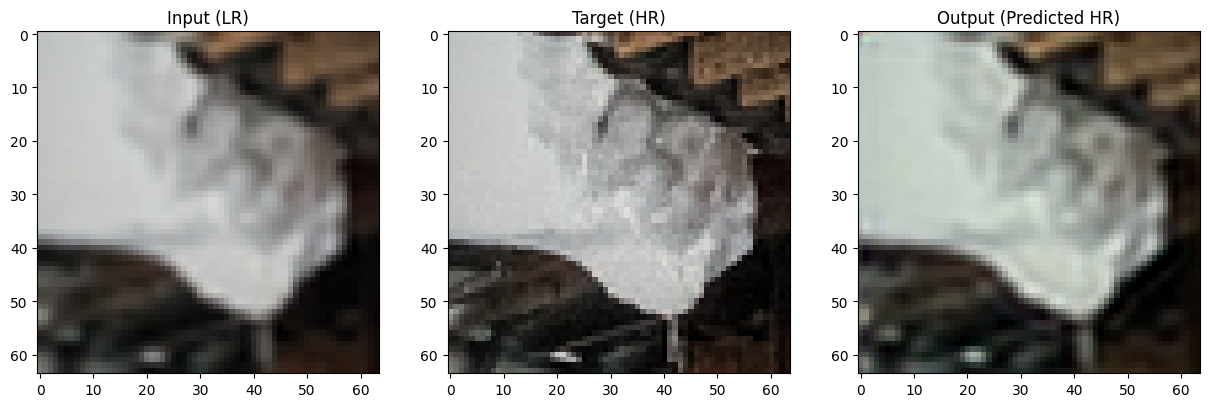

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

input, target = test_set[30]
output = model(input.unsqueeze(0).to(device))
output = output.squeeze(0).cpu().detach()
output = output.clamp(0.0, 1.0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(F.to_pil_image(input))
plt.title("Input (LR)")

plt.subplot(1, 3, 2)
plt.imshow(F.to_pil_image(target))
plt.title("Target (HR)")

plt.subplot(1, 3, 3)
plt.imshow(F.to_pil_image(output))
plt.title("Output (Predicted HR)")

plt.show()